In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import re

%matplotlib inline

In [2]:
#Supress warnings

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)

In [3]:
# read xlsx file 

df = pd.read_excel('book1.xlsx')

In [4]:
df.shape

(3544, 6)

In [5]:
df.head()

,User ID,User Name,BGBU,Question,Question Text,Answer
0,1,A,BG2-BU4,9,What did you like the most about Performance A...,IRM and HR discussion
1,2,B,BG6-BU8,9,What did you like the most about Performance A...,NaN
2,3,C,BG1-BU15,9,What did you like the most about Performance A...,HRPP provide the all information about apprais...
3,4,D,BG4-BU9,9,What did you like the most about Performance A...,HR Discussion.
4,5,E,BG6-BU2,9,What did you like the most about Performance A...,transparent process


In [6]:
# check the missing values 

total = df.isnull().sum().sort_values(ascending=False)
percent = round((df.isnull().sum()/df.isnull().count()  * 100).sort_values(ascending=False),2)
data_type = df.dtypes
missing_data = pd.concat([total,percent,data_type],axis=1,keys=['Total','Percent','Data_Type']).sort_values("Total", axis = 0, ascending = False)
missing_data.head()

,Total,Percent,Data_Type
Answer,736,20.77,object
User Name,4,0.11,object
Question Text,0,0.00,object
Question,0,0.00,int64
BGBU,0,0.00,object


In [7]:
# drop the missing record
df = df.dropna()

In [8]:
df.shape

(2804, 6)

In [9]:

total = df.isnull().sum().sort_values(ascending=False)
percent = round((df.isnull().sum()/df.isnull().count()  * 100).sort_values(ascending=False),2)
data_type = df.dtypes
missing_data = pd.concat([total,percent,data_type],axis=1,keys=['Total','Percent','Data_Type']).sort_values("Total", axis = 0, ascending = False)
missing_data.head()

,Total,Percent,Data_Type
Answer,0,0.0,object
Question Text,0,0.0,object
Question,0,0.0,int64
BGBU,0,0.0,object
User Name,0,0.0,object


In [10]:
# check duplicates 

df.duplicated().value_counts()

False    2804
dtype: int64

## Data cleaning and preprocessing

In [11]:
from textblob import TextBlob 
import pandas as pd
import time
import re 
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

In [12]:
def clean_text(text): 
    ''' 
    Utility function to clean text text by removing links, special characters 
    using simple regex statements. 
    '''
    return  re.sub("[^a-zA-Z]",  # Search for all non-letters
                          " ",          # Replace all non-letters with spaces
                          str(text).lower())


In [13]:
def remove_stop_word(text):
    """
    remove all the stop words from input text
    """
    
    stop_words = set(stopwords.words('english')) 
  
    word_tokens = word_tokenize(text) 

    filtered_sentence = [w for w in word_tokens if not w in stop_words] 

    filtered_sentence = [] 

    for w in word_tokens: 
        if w not in stop_words: 
            filtered_sentence.append(w) 
    
    return " ".join(filtered_sentence)

In [14]:
   
ps = PorterStemmer()
   

def steaming(text):
    """
    convert words to its base format for input sentence
    """
    
    words = word_tokenize(text)
    
    stem = []
    for w in words:
        stem.append(ps.stem(w))
    
    return " ".join(stem)
  

In [15]:
# clean answer text
df["Clean_Answer"] = df["Answer"].apply(lambda text: clean_text(text))

# remove all stop words 
df["No_stopword"] = df["Clean_Answer"].apply(lambda text: remove_stop_word(text))

# apply steaming
df["steming"] = df["No_stopword"].apply(lambda text: steaming(text))

In [16]:
df.head()

,User ID,User Name,BGBU,Question,Question Text,Answer,Clean_Answer,No_stopword,steming
0,1,A,BG2-BU4,9,What did you like the most about Performance A...,IRM and HR discussion,irm and hr discussion,irm hr discussion,irm hr discuss
2,3,C,BG1-BU15,9,What did you like the most about Performance A...,HRPP provide the all information about apprais...,hrpp provide the all information about apprais...,hrpp provide information appraisal process,hrpp provid inform apprais process
3,4,D,BG4-BU9,9,What did you like the most about Performance A...,HR Discussion.,hr discussion,hr discussion,hr discuss
4,5,E,BG6-BU2,9,What did you like the most about Performance A...,transparent process,transparent process,transparent process,transpar process
5,6,F,BG5-BU5,9,What did you like the most about Performance A...,Whole process is very simple and informative.,whole process is very simple and informative,whole process simple informative,whole process simpl inform


In [17]:
# check col names 
df.columns

Index(['User ID', 'User Name', 'BGBU', 'Question', 'Question Text', 'Answer',
       'Clean_Answer', 'No_stopword', 'steming'],
      dtype='object')

In [18]:
# create a vocabalary for all the stem answers

vocab = []

for row in df["steming"]:
    for word in row.split():
        vocab.append(word)

print("total words in answers: ", len(vocab))        


total words in answers:  8390


## Calculate Ploarity score 

In [19]:
from textblob import TextBlob

In [20]:
# list to store the words 
pos_vocab =  list()
neg_vocab = list()
ntrl_vocab = list()


for i in vocab:
    
    # predict the polarity score for each word 
    score =  list(TextBlob(i).sentiment)
    
    # if the score is between -0.3 and +0.3 then its neutral word
    if score[0] >= -0.3 and score[0] <= 0.3:
        ntrl_vocab.append(i)
        
    # score greater than 0.3 is +ve word    
    elif score[0] > 0.3:
        pos_vocab.append(i)
        
    # if score is less than -0.3 then its negative word
    elif score[0] < -0.3:
        neg_vocab.append(i)

        
# check total word len 
print("pos words: ", len(pos_vocab))
print("neg words: ", len(neg_vocab))
print("ntrl words: ", len(ntrl_vocab))

pos words:  1037
neg words:  32
ntrl words:  7321


In [21]:
# example of postive words

print(list(set(pos_vocab))[:15])

['wise', 'nice', 'better', 'sure', 'great', 'candid', 'superb', 'quick', 'good', 'fit', 'best', 'ok', 'sound', 'top', 'free']


In [22]:
# example of negative words

print(list(set(neg_vocab))[:15])

['mean', 'tough', 'rank', 'weak', 'base', 'poor', 'serious', 'worst', 'wrong', 'meaningless', 'bad', 'slow', 'difficult']


In [23]:
# example of neutral words

print(list(set(ntrl_vocab))[:15])

['agre', 'submissin', 'well', 'hope', 'plan', 'hike', 'rather', 'common', 'home', 'call', 'eg', 'junior', 'implement', 'pace', 'goog']


## Generate WordCloud

In [24]:
import matplotlib.pyplot as pPlot
from wordcloud import WordCloud, STOPWORDS
import numpy as npy
from PIL import Image

In [25]:

def create_word_cloud(string):
    """
    utility function to genrate wordcloud
    """
    cloud = WordCloud(max_words = 200,
                      width=400,
                      height=250,
                      min_font_size=6,
                      background_color='black', 
                      repeat=True,
                      stopwords = set(STOPWORDS))
    cloud.generate(string)
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

### Postive WordCloud 

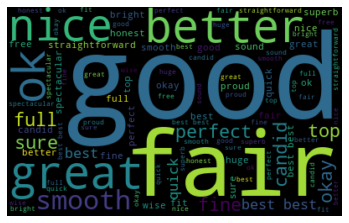

In [26]:
dataset = " ".join(pos_vocab)    
dataset = dataset.lower()
create_word_cloud(dataset)

### Negative WordCloud 

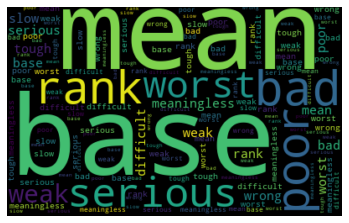

In [27]:
dataset = " ".join(neg_vocab)    
dataset = dataset.lower()
create_word_cloud(dataset)

### Neutral WordCloud 

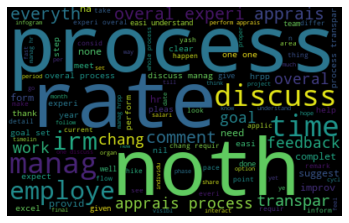

In [28]:
dataset = " ".join(ntrl_vocab)    
dataset = dataset.lower()
create_word_cloud(dataset)